### MULTIVATIATE JENA CLIMATE FOCASTING USING Bi-LSTM

In this notebook we are going to use the Jena Climate Dataset to build an `Bi-LSTM` model that will predict weather and climate. We are going to use the previous notebooks as reference to this.

### Imports

In the following code cell we are going to import all the packages that we will be using in this notebook.

In [18]:

import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from helperfns.tables import tabulate_data
from helperfns.utils import hms_string
from copy import deepcopy as dc
from sklearn.model_selection import train_test_split
from zipfile import ZipFile

print("Numpy: ", np.__version__)
print("Torch: ", torch.__version__)


Numpy:  1.26.4
Torch:  2.2.2


### Seed
Next we are going to set the seed to be `23` for reproducivity in this notebook.

In [2]:
SEED = 23
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Device
Next we are going to get the device to be `GPU` if we have GPU access.

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Loading data.

We are going to load our data from the `jena_climate_2009_2016.csv` file into a pandas dataframe.

In [4]:
dataframe = pd.read_csv('jena_climate_2009_2016.csv')
dataframe.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1


From our dataframe, if we look at the `Date Time` column we can see that the weather focus was in a `10minutes` interval. We want to make this to be an `hourly` interval so that our data will be a bit small.

In [5]:
dataframe = dataframe[5::6]
dataframe.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3


Then we want to make our `Date Time` an index column and change the format of our date time using the `to_datetime` function

In [6]:
dataframe.index = pd.to_datetime(dataframe['Date Time'], format='%d.%m.%Y %H:%M:%S')
dataframe.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3


For now we are going to focus on predicting the Temperature in `deg C`.


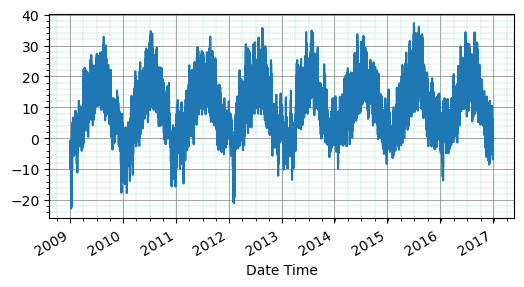

In [7]:
plt.figure(figsize=(6, 3))
temp = dataframe['T (degC)']
temp.plot()

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

From the data that we have just ploted we can see that there is a pattern in this data. Surely during the year the lower temperatures indicates `winter` temperatures that was recorded.

We are going to create a new dataframe that will contain the following columns.

1. `Temperature`
2. `Pressure`
3. `Second` - We are going to map our `Date Time` column to a column called seconds.

In [8]:
pressure = dataframe['p (mbar)']
new_df = pd.DataFrame({'Temperature':temp, 'Pressure': pressure})
new_df['Seconds'] = new_df.index.map(pd.Timestamp.timestamp)
new_df.head(2)

,Temperature,Pressure,Seconds
Date Time,,,
2009-01-01 01:00:00,-8.05,996.50,1.230772e+09
2009-01-01 02:00:00,-8.88,996.62,1.230775e+09


Now that we have our timestamp in seconds, We can now create more columns based on our timestamp columns which are:

1. ``Day Sin``
2. ``Day Cos``
3.  ``Year Sin``
4. ``Year Cos``

> This is very important to have these columns, as Temperature might be affected by the time of the day, and period of the year.

In [9]:
day = 60 * 60 * 24
year = 365.2425 * day

new_df['Day Sin'] = np.sin(new_df['Seconds'] * (2* np.pi / day))
new_df['Day Cos'] = np.cos(new_df['Seconds'] * (2 * np.pi / day))
new_df['Year Sin'] = np.sin(new_df['Seconds'] * (2 * np.pi / year))
new_df['Year Cos'] = np.cos(new_df['Seconds'] * (2 * np.pi / year))
new_df.head(2)

,Temperature,Pressure,Seconds,Day Sin,Day Cos,Year Sin,Year Cos
Date Time,,,,,,,
2009-01-01 01:00:00,-8.05,996.50,1.230772e+09,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,996.62,1.230775e+09,0.500000,0.866025,0.010766,0.999942


Next we are going to drop the `Seconds` column as follows:

In [11]:
new_df.drop(columns=["Seconds"], inplace=True)
new_df.head(2)

,Temperature,Pressure,Day Sin,Day Cos,Year Sin,Year Cos
Date Time,,,,,,
2009-01-01 01:00:00,-8.05,996.50,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,996.62,0.500000,0.866025,0.010766,0.999942


So we are going to predict temperature and pressure based on the previously recorded temperatures and pressure. We are going to set the default ``window_size``  to be 7. This means that we will use the previous 7 values to get the current value.

In [16]:

def dataframe_to_X_y(dataframe, window_size=7):
    values = dataframe.to_numpy()
    X = []
    y = []
    for i in range(len(values)-window_size):
        row = [r for r in values[i:i+window_size]]
        X.append(row)
        label = [values[i+window_size][0], values[i+window_size][1]]
        y.append(label)
  return np.array(X), np.array(y)
X, y = dataframe_to_X_y(new_df)
X.shape, y.shape

((70084, 7, 6), (70084, 2))

Next we are going to split our data into 3 subsets, which are

1. train
2. test
2. valid

In [55]:
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.10, shuffle=False) ## this is a time series prediction
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, shuffle=False) ## this is a time series prediction

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((56767, 7, 6), (56767, 2), (7009, 7, 6), (7009, 2), (6308, 7, 6), (6308, 2))

Next we are going to check the examples that are in each set using a table.

In [56]:
columns = ["Set", "Total"]
_data = [
    ["TRAINING", f"{len(X_train):,}"],
    ["TESTING", f"{len(X_test):,}"],
    ["VALIDATION", f"{len(X_val):,}"],
    ["TOTAL", f"{len(X_train) + len(X_test) + len(X_val):,}"],
]
tabulate_data(columns, _data, title="SETS EXAMPLES")

SETS EXAMPLES
+------------+--------+
| Set        |  Total |
+------------+--------+
| TRAINING   | 56,767 |
| TESTING    |  7,009 |
| VALIDATION |  6,308 |
| TOTAL      | 70,084 |
+------------+--------+


Next we are going to use the `StandardScaler` to scale our temperature and our pressure.

In [57]:
temp_scaler = StandardScaler()
pressure_scaler = StandardScaler()

In [58]:
def preprocess_features(X):
    temp = X[:, :, 0]
    pr = X[:, :, 1]
    X[:, :, 0] = temp_scaler.fit_transform(temp)
    X[:, :, 1] = pressure_scaler.fit_transform(pr)
    return X

def preprocess_output(y):
    temp = y[:, 0].reshape(-1, 1)
    pr = y[:, 1].reshape(-1, 1)
    y[:, 0] = temp_scaler.fit_transform(temp).flatten()
    y[:, 1] = pressure_scaler.fit_transform(pr).flatten()
    return y

In [59]:
preprocess_features(X_train)
preprocess_features(X_test)
preprocess_features(X_val)
print()

In [60]:
preprocess_output(y_train)
preprocess_output(y_test)
preprocess_output(y_val)

array([[ 1.42917785e-02, -1.41733850e+00],
       [ 1.24613118e-03, -1.43973880e+00],
       [-8.53295283e-02, -1.37253791e+00],
       ...,
       [-9.19064988e-01,  1.23933642e+00],
       [-8.84671918e-01,  1.28301699e+00],
       [-8.81114014e-01,  1.32893760e+00]])

Next we want to convert our features and labels to pytorch long tensors.

In [61]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

X_val = torch.from_numpy(X_val).float()
y_val = torch.tensor(y_val).float()

### Dataset

Next we are going to create a `ClimateFocastingDataset`, this will take the features and labels and we will use this one to batch our data before training

In [62]:
class ClimateFocastingDataset(Dataset):
    def __init__(self, X, y):
        super(ClimateFocastingDataset, self).__init__()
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.y[index], self.X[index]

Let's create the dataset for each set.

In [63]:
train_dataset = ClimateFocastingDataset(X_train, y_train)
test_dataset = ClimateFocastingDataset(X_test, y_test)
val_dataset = ClimateFocastingDataset(X_val, y_val)

Next we are going to batch our data, we are going to set the batchsize to be `64`. We are going to turn on the shuffle of the train dataset only.

In [64]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Let's check a single example in the first batch, in the training dataset

In [65]:
for batch in train_loader:break

In [66]:
batch[0][:3]

tensor([[-0.6864,  0.3264],
        [-1.2745,  0.3756],
        [ 0.1364, -0.4495]])

In [67]:
batch[1][0]

tensor([[-1.2409e-01, -1.1828e-01, -8.6603e-01,  5.0000e-01, -1.2148e-01,
          9.9259e-01],
        [-4.8274e-02, -1.3507e-01, -7.0711e-01,  7.0711e-01, -1.2077e-01,
          9.9268e-01],
        [-6.7287e-02, -1.0500e-01, -5.0000e-01,  8.6603e-01, -1.2006e-01,
          9.9277e-01],
        [-4.2653e-01,  4.7579e-02, -2.5882e-01,  9.6593e-01, -1.1935e-01,
          9.9285e-01],
        [-4.6215e-01,  1.5091e-01,  2.4642e-13,  1.0000e+00, -1.1863e-01,
          9.9294e-01],
        [-4.9067e-01,  2.0140e-01,  2.5882e-01,  9.6593e-01, -1.1792e-01,
          9.9302e-01],
        [-5.4646e-01,  3.1555e-01,  5.0000e-01,  8.6603e-01, -1.1721e-01,
          9.9311e-01]])

### Model

Next thing we want to build an ``Bi-LSTM`` model that will train on this data.

In [72]:

class ClimateFocastingBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.5, bidirectional=False):
        super(ClimateFocastingBiLSTM, self).__init__()
    
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2 if bidirectional else hidden_size, 8),
            nn.ReLU(inplace=False),
            nn.Linear(8, output_size),
        )
        self.dropout = nn.Dropout(dropout/3)

    def forward(self, x):
        batch_size = x.size(0)
        device = x.device
        h0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, 
                         batch_size, 
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, 
                         batch_size, 
                         self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.out(out[:, -1, :])
        return out
        
INPUT_DIM = 6
HIDDEN_DIM = 64
OUTPUT_DIM = 2 
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.75

model_1 = ClimateFocastingBiLSTM(
    INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, 
    num_layers = N_LAYERS, 
    bidirectional = BIDIRECTIONAL, 
    dropout = DROPOUT
).to(device)
model_1

ClimateFocastingBiLSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, dropout=0.75, bidirectional=True)
  (out): Sequential(
    (0): Linear(in_features=128, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
)

Next we are going to count the model parameters.

In [73]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["model", *count_trainable_params(model_1)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+-------+--------------+------------------+
| MODEL | TOTAL PARAMS | TRAINABLE PARAMS |
+-------+--------------+------------------+
| model |      137,242 |          137,242 |
+-------+--------------+------------------+


Next we are going to create the `optimizer` and `loss` function. For the loss function i will use the `MSELoss` and for the optmizer i will use the `Adam`.

In [74]:
optimizer = torch.optim.Adam(model_1.parameters())
criterion = nn.MSELoss().to(device)

Next we are going to define our train and evaluate functions. 

1. `train`
- Keep in track of the avarage `mse` loss per epoch
- Put the model in train mode
- Zero the gradients
- Make prediction
- Calculate the loss
- Update the weights

2. `evaluate`
- We don't need to compute the gradients
- Keep in track of the avarage `mse` loss per epoch
- Put the model in train mode
- Make prediction
- Calculate the loss

In [75]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    model.train(True)
    for y, X in iterator:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        predictions = model(X)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss =  0
  model.eval()
  with torch.no_grad():
    for y, X in iterator:
      X = X.to(device)
      y = y.to(device)
      predictions = model(X)
      loss = criterion(predictions, y)
      epoch_loss += loss.item()
  return epoch_loss / len(iterator)

### Training Loop.
When training the model. And we are also going to keep on tracking the training history of each model. The following History class is a data structure for our training history.

In [76]:
class History:
    def __init__(self):
        self.train_losses = list()
        self.epoch_train_time = list()
        self.val_losses = list()
    def add(self, train_loss:float, val_loss:float, elt:float):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.epoch_train_time.append(elt)

We are going to train the model for `10` epochs.

In [77]:
def run_train_loop(model, model_name, train_loader, val_loader,  epochs=20, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, valid_loss, end-start)
    data = [
        ["Training", f'{train_loss:.3f}',  f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}',  "" ],
    ]
    columns = ["CATEGORY", "LOSS (mse)", "ETA"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In [78]:
EPOCHS = 10
history, elt, last_saved_epoch = run_train_loop(
    model_1, 'bi-ltsm-model-1.pt', train_loader, val_loader, EPOCHS,
    optimizer=optimizer, criterion=criterion
)

EPOCH: 01/10 saving best model...
+------------+------------+------------+
| CATEGORY   | LOSS (mse) |        ETA |
+------------+------------+------------+
| Training   |      0.091 | 0:00:44.97 |
| Validation |      0.012 |            |
+------------+------------+------------+
EPOCH: 02/10 saving best model...
+------------+------------+------------+
| CATEGORY   | LOSS (mse) |        ETA |
+------------+------------+------------+
| Training   |      0.028 | 0:00:42.39 |
| Validation |      0.009 |            |
+------------+------------+------------+
EPOCH: 03/10 not saving...
+------------+------------+------------+
| CATEGORY   | LOSS (mse) |        ETA |
+------------+------------+------------+
| Training   |      0.023 | 0:00:44.33 |
| Validation |      0.009 |            |
+------------+------------+------------+
EPOCH: 04/10 saving best model...
+------------+------------+------------+
| CATEGORY   | LOSS (mse) |        ETA |
+------------+------------+------------+
| Training

Let's visualize the training history.

In [79]:
rows = [
      ["TOTAL EPOCHS", f'{EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(elt)}']
]
tabulate_data(['', 'value'], rows, "MODEL TOTAL TRAINING TIME AND LAST SAVED EPOCH")

MODEL TOTAL TRAINING TIME AND LAST SAVED EPOCH
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         10 |
| LAST SAVED EPOCH    |          7 |
| TOTAL TRAINING TIME | 0:07:43.39 |
+---------------------+------------+


Let's check how long the model took to train each epoch.

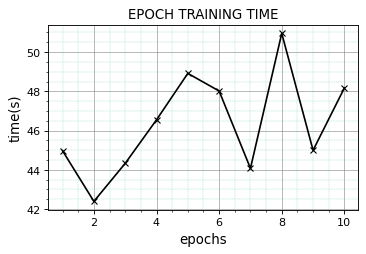

In [80]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, "x-", color='k', label='ett')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Let's visialize the training and validation losses that was observed during training the model.

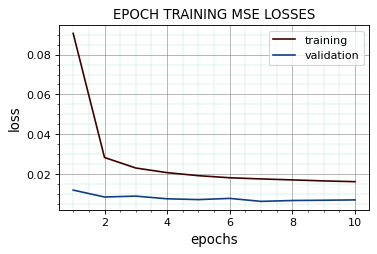

In [81]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, color='#3D0301', label='training')
plt.plot(epochs, history.val_losses, color='#133E87', label='validation')
plt.title("EPOCH TRAINING MSE LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

In the next code cell we are going to evaluate our best model on the test data using the `MSE`.

In [82]:
model_1.load_state_dict(torch.load('bi-ltsm-model-1.pt'))
test_loss = evaluate(model_1, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f}')

Test Loss: 0.007


Let's make some predictions based on our data.

In [84]:
def predict(model, X, device):
    with torch.no_grad():
        predictions = model(X.to(device)).to('cpu').numpy()
    temp_preds, p_preds = predictions[:, 0], predictions[:, 1]
    return temp_preds, p_preds
    
train_temp_preds, train_p_preds = predict(model_1, X_train, device)
test_temp_preds, test_p_preds = predict(model_1, X_test, device)
val_temp_preds, val_p_preds = predict(model_1, X_val, device)

Next we are going to take get our real values.

In [85]:
train_temp_actuals, train_p_actuals = y_train[:, 0], y_train[:, 1]
test_temp_actuals, test_p_actuals = y_test[:, 0], y_test[:, 1]
val_temp_actuals, val_p_actuals = y_val[:, 0], y_val[:, 1]

Then we will generate `3` dataframes using the predicted values.

In [86]:
train_pred_df = pd.DataFrame(
    data={
      'Temperature Predictions': train_temp_preds,
      'Temperature Actuals':train_temp_actuals,
      'Pressure Predictions': train_p_preds,
      'Pressure Actuals': train_p_actuals
    }
)
test_pred_df = pd.DataFrame(
    data={
      'Temperature Predictions': test_temp_preds,
      'Temperature Actuals':test_temp_actuals,
      'Pressure Predictions': test_p_preds,
      'Pressure Actuals': test_p_actuals
    }
)
val_pred_df = pd.DataFrame(
    data={
      'Temperature Predictions': val_temp_preds,
      'Temperature Actuals':val_temp_actuals,
      'Pressure Predictions': val_p_preds,
      'Pressure Actuals': val_p_actuals
    }
)

In [87]:
train_pred_df.head(5)

,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,-2.142674,-2.035710,1.083589,1.238065
1,-2.007553,-1.983541,1.157526,1.300525
2,-1.909874,-1.910030,1.227268,1.370191
3,-1.819332,-1.953900,1.292884,1.442259
4,-1.827337,-1.889874,1.361518,1.373794


In [88]:
test_pred_df.head()

,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,-1.156038,-1.160183,1.364100,1.438114
1,-1.155014,-1.197139,1.400086,1.470489
2,-1.185295,-1.264680,1.420088,1.451064
3,-1.252422,-1.272326,1.404592,1.443294
4,-1.279898,-1.264680,1.383557,1.440704


In [89]:
val_pred_df.head()

,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,-0.029408,0.014292,-1.400426,-1.417338
1,-0.034516,0.001246,-1.474304,-1.439739
2,-0.034266,-0.085330,-1.501162,-1.372538
3,-0.091428,-0.103119,-1.434798,-1.253816
4,-0.108398,-0.104305,-1.292304,-1.135095


Before we do any plotting we need to do the inverse transformation for the temperature and pressure. For that we are going to create a postprocessing functions for both the temperature and pressure.

In [98]:
def postprocess_temperature(arr):
  arr = temp_scaler.inverse_transform(arr.reshape(-1, 1)).flatten()
  return arr

def postprocess_pressure(arr):
  arr = pressure_scaler.inverse_transform(arr.reshape(-1, 1)).flatten()
  return arr

Let's check the predictions in the training data. We are going to plot the first `150` temperature predictions.

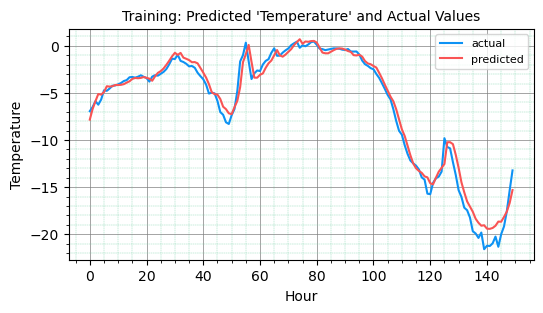

,actuals,predicted
0,-6.935474,-7.837387
1,-6.495590,-6.698057
2,-5.875749,-5.874433
3,-6.245655,-5.110993
4,-5.705795,-5.178486
5,-4.726049,-4.913762
6,-4.776036,-4.289244
7,-4.526101,-4.326841
8,-4.236176,-4.286630
9,-4.206184,-4.157427


In [101]:
train_true = postprocess_temperature(train_pred_df["Temperature Actuals"].values)[:150]
train_preds =  postprocess_temperature(train_pred_df["Temperature Predictions"].values)[:150]

plt.figure(figsize=(6, 3))
plt.plot(train_true, label='actual', color="#0D92F4")
plt.plot(train_preds, label='predicted', color="#F95454")
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Temperature', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Training: Predicted 'Temperature' and Actual Values", fontsize=10)
plt.show()

train_preds_dataframe = pd.DataFrame({ "actuals": train_true , "predicted": train_preds})
train_preds_dataframe.head(10)

Let's do the same to the pressure.

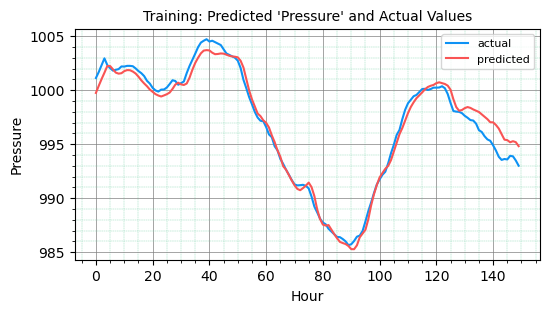

,actuals,predicted
0,1001.118652,999.739441
1,1001.676331,1000.399536
2,1002.298340,1001.022217
3,1002.941772,1001.608093
4,1002.330505,1002.220886
5,1002.040955,1002.230103
6,1001.804993,1001.929688
7,1001.880066,1001.620667
8,1001.944397,1001.525146
9,1002.191101,1001.564148


In [104]:
train_true = postprocess_pressure(train_pred_df["Pressure Actuals"].values)[:150]
train_preds =  postprocess_pressure(train_pred_df["Pressure Predictions"].values)[:150]

plt.figure(figsize=(6, 3))
plt.plot(train_true, label='actual', color="#0D92F4")
plt.plot(train_preds, label='predicted', color="#F95454")
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Pressure', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Training: Predicted 'Pressure' and Actual Values", fontsize=10)
plt.show()

train_preds_dataframe = pd.DataFrame({ "actuals": train_true , "predicted": train_preds})
train_preds_dataframe.head(10)

Let's check the predictions in the validation data. We are going to plot the first `150` temperature predictions.

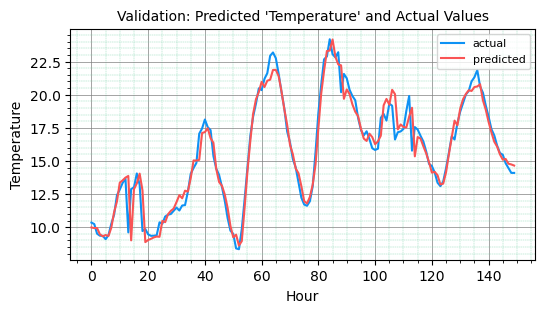

,actuals,predicted
0,10.35,9.981529
1,10.24,9.938456
2,9.51,9.940560
3,9.36,9.458574
4,9.35,9.315486
5,9.10,9.412127
6,9.39,9.337779
7,10.25,9.956462
8,10.95,11.128201
9,12.41,11.949198


In [105]:
val_true = postprocess_temperature(val_pred_df["Temperature Actuals"].values)[:150]
val_preds =  postprocess_temperature(val_pred_df["Temperature Predictions"].values)[:150]

plt.figure(figsize=(6, 3))
plt.plot(val_true, label='actual', color="#0D92F4")
plt.plot(val_preds, label='predicted', color="#F95454")
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Temperature', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Validation: Predicted 'Temperature' and Actual Values", fontsize=10)
plt.show()

val_preds_dataframe = pd.DataFrame({ "actuals": val_true , "predicted": val_preds})
val_preds_dataframe.head(10)

Let's plot the pressure in the validation set for the predicted values and actual values.

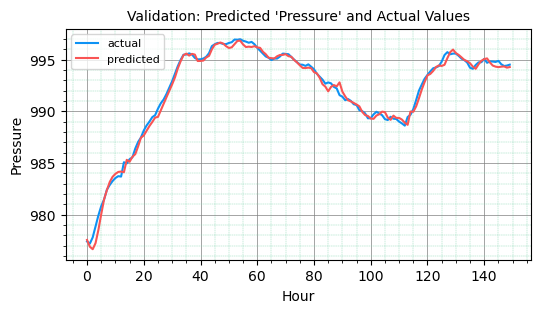

,actuals,predicted
0,977.409973,977.560974
1,977.210022,976.901367
2,977.809998,976.661560
3,978.869995,977.254089
4,979.929993,978.526367
5,980.830017,980.051208
6,981.469971,981.478394
7,982.419983,982.385132
8,982.880005,983.165771
9,983.260010,983.666870


In [107]:
val_true = postprocess_pressure(val_pred_df["Pressure Actuals"].values)[:150]
val_preds =  postprocess_pressure(val_pred_df["Pressure Predictions"].values)[:150]

plt.figure(figsize=(6, 3))
plt.plot(val_true, label='actual', color="#0D92F4")
plt.plot(val_preds, label='predicted', color="#F95454")
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Pressure', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Validation: Predicted 'Pressure' and Actual Values", fontsize=10)
plt.show()

val_preds_dataframe = pd.DataFrame({ "actuals": val_true , "predicted": val_preds})
val_preds_dataframe.head(10)

Let's check the predictions in the testing data. We are going to plot the first `150` temperature predictions.

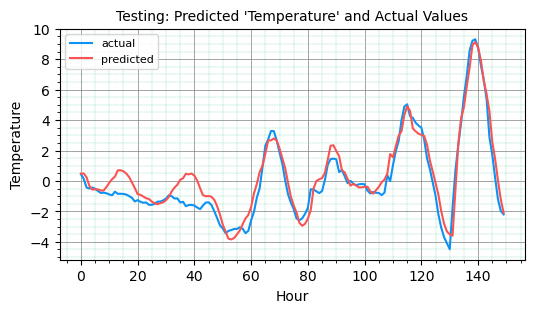

,actuals,predicted
0,0.446911,0.481857
1,0.135299,0.490497
2,-0.434199,0.235170
3,-0.498670,-0.330846
4,-0.434199,-0.562521
5,-0.509416,-0.544859
6,-0.659849,-0.555312
7,-0.788791,-0.621869
8,-0.767301,-0.631812
9,-0.810281,-0.396831


In [108]:

test_true = postprocess_temperature(test_pred_df["Temperature Actuals"].values)[:150]
test_preds =  postprocess_temperature(test_pred_df["Temperature Predictions"].values)[:150]

plt.figure(figsize=(6, 3))
plt.plot(test_true, label='actual', color="#0D92F4")
plt.plot(test_preds, label='predicted', color="#F95454")
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Temperature', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Testing: Predicted 'Temperature' and Actual Values", fontsize=10)
plt.show()

test_preds_dataframe = pd.DataFrame({ "actuals": test_true , "predicted": test_preds})
test_preds_dataframe.head(10)


Let's do the same for pressure.

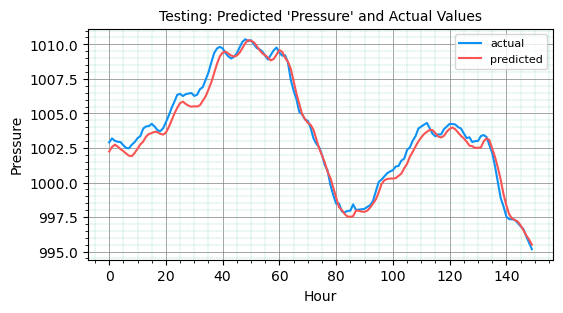

,actuals,predicted
0,1002.904785,1002.243958
1,1003.193848,1002.565247
2,1003.020386,1002.743835
3,1002.951050,1002.605469
4,1002.927917,1002.417664
5,1002.696655,1002.274231
6,1002.500061,1002.092957
7,1002.476929,1001.935852
8,1002.742920,1001.911072
9,1002.927917,1002.143677


In [109]:
test_true = postprocess_pressure(test_pred_df["Pressure Actuals"].values)[:150]
test_preds =  postprocess_pressure(test_pred_df["Pressure Predictions"].values)[:150]

plt.figure(figsize=(6, 3))
plt.plot(test_true, label='actual', color="#0D92F4")
plt.plot(test_preds, label='predicted', color="#F95454")
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Pressure', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Testing: Predicted 'Pressure' and Actual Values", fontsize=10)
plt.show()

test_preds_dataframe = pd.DataFrame({ "actuals": test_true , "predicted": test_preds})
test_preds_dataframe.head(10)